In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
print(label_enc)

{'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20}


In [7]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


# Train

In [8]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [10]:
from tensorflow import keras

In [16]:
# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

# meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
n_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(n)
n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

c = tf.keras.layers.Input(shape=((15,)))
c_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(c)
c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

m1 = tf.keras.layers.Input(shape=((15,)))
m1_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m1)
m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

m2 = tf.keras.layers.Input(shape=((15,)))
m2_embed = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m2)
m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
# net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
# net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(n_embed)
n_lstm = tf.keras.layers.Dense(8, activation='relu')(n_lstm)
n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(c_embed)
c_lstm = tf.keras.layers.Dense(8, activation='relu')(c_lstm)
c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m1_embed)
m1_lstm = tf.keras.layers.Dense(8, activation='relu')(m1_lstm)
m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(m2_embed)
m2_lstm = tf.keras.layers.Dense(8, activation='relu')(m2_lstm)
m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

pep_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(pep_embed)
pep_lstm = tf.keras.layers.Dense(16, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)


# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
#                                      net_meta,
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm])
net_merge = tf.keras.layers.Dense(64, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(32, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[pep, 
#                                     meta,
                                    n, c, m1, m2],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(5e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 15)]         0                                            
____________________________________________________________________________________________

In [17]:
history = model_high.fit([pep_train, 
#                           aa_train, 
                          en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=128,
                    validation_data=([pep_val, 
#                                       aa_val,
                                      en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
4247/4247 [==============================] - 410s 91ms/step - loss: 0.5044 - accuracy: 0.7559 - val_loss: 0.4361 - val_accuracy: 0.7965
Epoch 2/300
4247/4247 [==============================] - 374s 88ms/step - loss: 0.4397 - accuracy: 0.7966 - val_loss: 0.4185 - val_accuracy: 0.8098
Epoch 3/300
4247/4247 [==============================] - 405s 95ms/step - loss: 0.4235 - accuracy: 0.8069 - val_loss: 0.4127 - val_accuracy: 0.8125
Epoch 4/300
4247/4247 [==============================] - 411s 97ms/step - loss: 0.4178 - accuracy: 0.8096 - val_loss: 0.4049 - val_accuracy: 0.8174
Epoch 5/300
4247/4247 [==============================] - 407s 96ms/step - loss: 0.4130 - accuracy: 0.8122 - val_loss: 0.4095 - val_accuracy: 0.8134
Epoch 6/300
4247/4247 [==============================] - 398s 94ms/step - loss: 0.4103 - accuracy: 0.8141 - val_loss: 0.3997 - val_accuracy: 0.8189
Epoch 7/300
4247/4247 [==============================] - 397s 93ms/step - loss: 0.4063 - accuracy: 0.8157 - val_

4247/4247 [==============================] - 402s 95ms/step - loss: 0.3708 - accuracy: 0.8353 - val_loss: 0.3744 - val_accuracy: 0.8331
Epoch 57/300
4247/4247 [==============================] - 416s 98ms/step - loss: 0.3707 - accuracy: 0.8362 - val_loss: 0.3767 - val_accuracy: 0.8322
Epoch 58/300
4247/4247 [==============================] - 411s 97ms/step - loss: 0.3717 - accuracy: 0.8350 - val_loss: 0.3757 - val_accuracy: 0.8336
Epoch 59/300
4247/4247 [==============================] - 406s 96ms/step - loss: 0.3711 - accuracy: 0.8348 - val_loss: 0.3750 - val_accuracy: 0.8327
Epoch 60/300
4247/4247 [==============================] - 401s 94ms/step - loss: 0.3715 - accuracy: 0.8356 - val_loss: 0.3741 - val_accuracy: 0.8332
Epoch 61/300
4247/4247 [==============================] - 411s 97ms/step - loss: 0.3705 - accuracy: 0.8358 - val_loss: 0.3736 - val_accuracy: 0.8336
Epoch 62/300
4247/4247 [==============================] - 416s 98ms/step - loss: 0.3694 - accuracy: 0.8365 - val_loss: 

Epoch 111/300
4247/4247 [==============================] - 417s 98ms/step - loss: 0.3630 - accuracy: 0.8397 - val_loss: 0.3737 - val_accuracy: 0.8346
Epoch 112/300
4247/4247 [==============================] - 416s 98ms/step - loss: 0.3640 - accuracy: 0.8392 - val_loss: 0.3739 - val_accuracy: 0.8328
Epoch 113/300
4247/4247 [==============================] - 416s 98ms/step - loss: 0.3633 - accuracy: 0.8398 - val_loss: 0.3760 - val_accuracy: 0.8326
Epoch 114/300
4247/4247 [==============================] - 415s 98ms/step - loss: 0.3631 - accuracy: 0.8392 - val_loss: 0.3726 - val_accuracy: 0.8340
Epoch 115/300
4247/4247 [==============================] - 413s 97ms/step - loss: 0.3634 - accuracy: 0.8398 - val_loss: 0.3731 - val_accuracy: 0.8342
Epoch 116/300
4247/4247 [==============================] - 414s 98ms/step - loss: 0.3641 - accuracy: 0.8389 - val_loss: 0.3730 - val_accuracy: 0.8341
Epoch 117/300
4247/4247 [==============================] - 415s 98ms/step - loss: 0.3618 - accuracy:

In [18]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

4188/4188 [==============================] - 70s 17ms/step - loss: 0.3664 - accuracy: 0.8383
Test Loss: 0.3663899600505829
Test Accuracy: 0.8383261561393738
              precision    recall  f1-score   support

           0       0.86      0.81      0.83     66996
           1       0.82      0.87      0.84     66996

    accuracy                           0.84    133992
   macro avg       0.84      0.84      0.84    133992
weighted avg       0.84      0.84      0.84    133992

rf auc : 0.9181100971981146


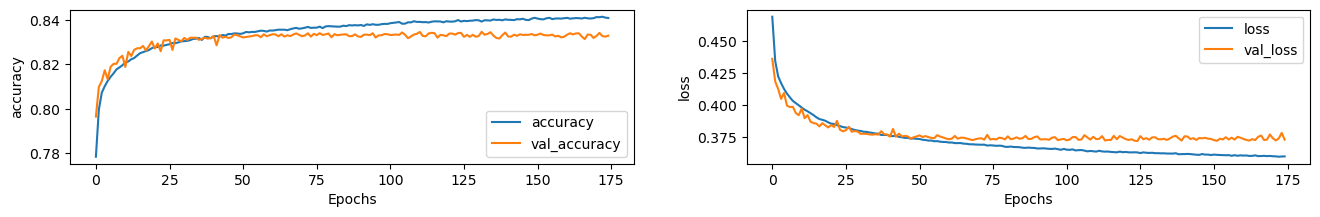

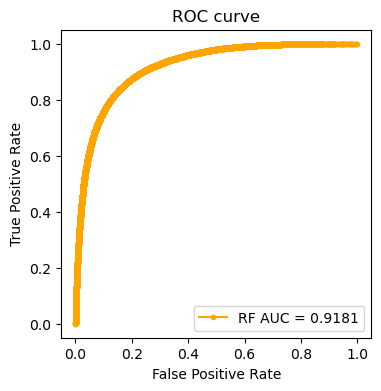

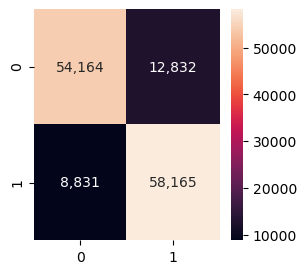

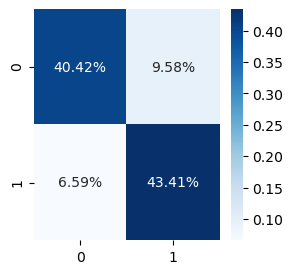

In [19]:
test_loss, test_acc = model_high.evaluate([pep_test, 
#                                            aa_test, 
                                           en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, 
#                                                           aa_test,
                                                          en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, 
#                             aa_test, 
                            en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

In [11]:
# # Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model_high.save("noAA.h5")

# It can be used to reconstruct the model identically.
model_high = keras.models.load_model("noAA.h5")

# HPP

In [12]:
import sys
PATH_TO_REPO = "/home/bis/2021_SJH_detectability/Detectability/"
sys.path.append(PATH_TO_REPO)
from utils import *

df_hpp = pd.read_csv('compareModel/2019Bioinformatics_DeepMSPeptide/Datasets/HPP_validation_peptides.txt', sep='\t')
df_hpp_under30 = df_hpp.loc[df_hpp.Peptide_seq.apply(lambda x: len(x)<=30 and len(x) >= 7)].reset_index(drop=True)
df_uni = pd.read_csv('../data/uniprot/df_uni.csv')

pep2cnt = dict()
cnt = 2
for p in df_hpp_under30.Peptide_seq.values:
    if p not in pep2cnt:
        pep2cnt[p] = 0
    pep2cnt[p] += cnt

pep_tree = tree_from_pep(df_hpp_under30.Peptide_seq.unique())

def pep_from_prot(df_uni, MISS_CLEAVAGE, thres=4):
    peptide = []
    TS_AA = 'KR'

    for protein, pname in df_uni[['SEQUENCE', 'PROTEIN']].values:
        
        ts_idx = []  # tryptic site index
        for prot_idx, aa in enumerate(protein):
            if aa in TS_AA:
                ts_idx.append(prot_idx)
        for idx in range(len(ts_idx)):
            n = MISS_CLEAVAGE
            if idx+(n+1) > len(ts_idx)-1:  # peptide making range
                break

            # protein N term
            if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            elif ts_idx[idx]<=(thres - 1):
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)]
            elif ts_idx[idx] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
                en = protein[ts_idx[idx]-thres:] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            else:
                en = protein[ts_idx[idx]-thres: ts_idx[idx]+(thres + 1)]

            # protein C term
            if (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)) and (ts_idx[idx+n+1] <= (thres - 1)):
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]  + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):
                ec = protein[ts_idx[idx+n+1] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] <= (thres - 1):  # for -MRRS : 시작이 부족한 경우
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]
            else:
                ec = protein[ts_idx[idx+n+1] - thres : ts_idx[idx+n+1] +(thres + 1)]  # n+1번째 tryptic_site
                    
            # Peptide miss cleavage
            if n != 0:  # miss cleavage 고려하는 경우,
                ei = []
                for i in range(1, n+1):
                    if (ts_idx[idx+i] <= (thres - 1)) and (ts_idx[idx+i] >= len(protein) -1 -(thres - 1)):
                        # both padding case
                        ei_tmp = 'Z' * (thres - ts_idx[idx+i]) + protein + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+i]))
                        
                    elif ts_idx[idx+i] >= len(protein) -1 -(thres - 1):
                        # 'MTTRGFSCLLLLI R EIDLSAKRRI' : ts_idx= 3, 13, 20, 21, 22
                        # -> N_term : 3, C_term : 20, m1_term : 13 in miss_cleavage==1 case
                        # ts_idx[idx+i]=13, len(protein)-1-(thres-1)=24-1-14=9, if True case.
                        # right padding case.
                        ei_tmp = protein[ts_idx[idx+i] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+i]))
                        
                    elif ts_idx[idx+i] <= (thres - 1):
                        # left padding case
                        ei_tmp = 'Z' * (thres - ts_idx[idx+i]) + protein[: ts_idx[idx+i]+(thres + 1)]
                    
                    else:
                        # no pad case.
                        ei_tmp = protein[ts_idx[idx+i] - thres : ts_idx[idx+i] +(thres + 1)]
                    ei.append(ei_tmp)
            else:  # miss cleavage 고려안하는 경우
                ei = []
            # peptide
            if ts_idx[idx+n+1] == len(protein)-1:  # protein C term = idx + n + 1 의 tryptic_site 가 단백질의 마지막인 경우
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.Z'
            else:
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.' + protein[ts_idx[idx+n+1]+1]

            peptide.append({pep:[[en], [ec], ei, pname]})
    return peptide

def pep_detection_labelling(df_ided_protein=df_uni, pep_tree=pep_tree, pep2cnt=pep2cnt):
    peptide0 = pep_from_prot(df_ided_protein, 0, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide0]
    ens = [list(dic.values())[0][0] for dic in peptide0]
    ecs = [list(dic.values())[0][1] for dic in peptide0]
    eis = [list(dic.values())[0][2] for dic in peptide0]
    pname = [list(dic.values())[0][3] for dic in peptide0]
    zero = pd.DataFrame([[p, n[0], c[0], '-', '-', pn] 
                         for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    zero['PEP'] = [i.split('.')[1] for i in zero.peptide.values]

    peptide1 = pep_from_prot(df_ided_protein, 1, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide1]
    ens = [list(dic.values())[0][0] for dic in peptide1]
    ecs = [list(dic.values())[0][1] for dic in peptide1]
    eis = [list(dic.values())[0][2] for dic in peptide1]
    pname = [list(dic.values())[0][3] for dic in peptide1]
    one = pd.DataFrame([[p, n[0], c[0], m[0], '-', pn]
                        for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    one['PEP'] = [i.split('.')[1] for i in one.peptide.values]

    peptide2 = pep_from_prot(df_ided_protein, 2, thres=7)
    peps = [list(dic.keys())[0] for dic in peptide2]
    ens = [list(dic.values())[0][0] for dic in peptide2]
    ecs = [list(dic.values())[0][1] for dic in peptide2]
    eis = [list(dic.values())[0][2] for dic in peptide2]
    pname = [list(dic.values())[0][3] for dic in peptide2]
    two = pd.DataFrame([[p, n[0], c[0], m[0], m[1], pn]
                        for p, n, c, m, pn in zip(peps, ens, ecs, eis, pname)],
                columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'protein'])
    two['PEP'] = [i.split('.')[1] for i in two.peptide.values]

    zero_filter = zero.loc[zero.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]
    one_filter = one.loc[one.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]
    two_filter = two.loc[two.PEP.apply(lambda x: (len(x)>=7) and (len(x)<=30))]

    df_fully = pd.concat([zero_filter, one_filter, two_filter], axis=0).reset_index(drop=True)

    # preprocessing
    amino = list("ARNDCEQGHILKMFPSTWYVZ")
    check_u = [idx for idx, t in enumerate(df_fully.PEP.values) if 'U' in t]
    check_x = [idx for idx, t in enumerate(df_fully.PEP.values) if 'X' in t]
    check_n = [idx for idx, t in enumerate(df_fully.En.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_c = [idx for idx, t in enumerate(df_fully.Ec.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_1 = [idx for idx, t in enumerate(df_fully.E1.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check_2 = [idx for idx, t in enumerate(df_fully.E2.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
    check = list(set(check_n).union(set(check_c)).union(set(check_1)).union(set(check_2)).union(set(check_u)).union(set(check_x)))
    print('del rows(including U, X amino acid) cnt : {:,}'.format(len(check)))
    df_fully = df_fully.drop(check).reset_index(drop=True)

    ided = []
    for fully_pep in df_fully.PEP.values:
        results = [i for i in pep_tree.search_all(fully_pep)]
        if len(results) != 0:
            result_pep = [_[0] for _ in results]
            if fully_pep in result_pep:  # 정확히 똑같은 pep 있는 경우
                if pep2cnt[fully_pep] > 1:
                    ided.append(1)
                else:
                    ided.append(-1)  # SC1인 경우는 제거하자
            else:
                ided.append(0)
        else:
            ided.append(0)
    df_fully['ID'] = ided

    drop_idx = df_fully.loc[df_fully.ID==-1].index
    print('peptide with 1 spectral count (remove this peptide) cnt : ', len(drop_idx))
    df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

    drop_idx = np.where(df_fully.duplicated()==True)[0]
    df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

    print('----ID/nonID cnt----\n', df_fully.ID.value_counts())  # massIVE-KB : half is semi_non_tryptic, half is fully_tryptic
    print('----final shape----\n', df_fully.shape)
    df_fully.head(1)
    return df_fully

df_hpp_ = pep_detection_labelling()

df_hpp_ = df_hpp_.loc[df_hpp_.ID==1]

print(df_hpp_.shape)
df_hpp_.head(2)

unip = set(df_hpp_.PEP.unique())
hppp = set(df_hpp_under30.Peptide_seq.unique())
nonp = hppp.difference(unip)

print(len(hppp)-len(unip))

del rows(including U, X amino acid) cnt : 11,806
peptide with 1 spectral count (remove this peptide) cnt :  0
----ID/nonID cnt----
 0    4743073
1      47314
Name: ID, dtype: int64
----final shape----
 (4790387, 8)
(47314, 8)
953


In [13]:
print('total hpp dataset cnt : {}\n \
7<= <=30 filtration cnt : {}\n \
semi trpytic cnt : {}'.format(len(df_hpp), len(df_hpp)-len(df_hpp_under30), len(hppp)-len(unip)))

print('remain HPP peptides cnt : ', len(unip))

df_hpp_uniq = df_hpp_[['peptide', 'En', 'Ec', 'E1', 'E2', 'PEP', 'ID']].drop_duplicates().reset_index(drop=True)
df_hpp_uniq = df_hpp_uniq.merge(df_hpp, left_on='PEP', right_on='Peptide_seq', how='inner').drop(['Peptide_seq'], axis=1)

print(df_hpp_uniq.shape)

total hpp dataset cnt : 23910
 7<= <=30 filtration cnt : 3046
 semi trpytic cnt : 953
remain HPP peptides cnt :  19911
(21522, 8)


In [14]:
aa, pep, en, ec, e1, e2, y = get_data_labelEnc(df_hpp_uniq)
print(aa.shape, pep.shape, en.shape, ec.shape, e1.shape, e2.shape, y.shape)

(21522, 39) (21522, 30) (21522, 15) (21522, 15) (21522, 15) (21522, 15) (21522,)


In [15]:
probs = model_high.predict([pep, en, ec, e1, e2])

In [16]:
df_hpp_uniq['probs'] = probs

In [17]:
dmp = df_hpp_uniq.loc[df_hpp_uniq.Class=='Detected_MPs']
mp = df_hpp_uniq.loc[df_hpp_uniq.Class=='MPs']
pe = df_hpp_uniq.loc[df_hpp_uniq.Class=='PE1']

In [18]:
dmp['Class'] = 'Detected MPs'
mp['Class'] = 'Current MPs'

/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
df_hpp_uniq_ = pd.concat([dmp, mp, pe], axis=0).reset_index(drop=True)

In [20]:
df_sns = df_hpp_uniq_[['Class', 'probs']]

In [21]:
df_sns.columns = ['_', 'Detection probability']

In [22]:
df_sns.head(2)

,_,Detection probability
0,Detected MPs,0.932916
1,Detected MPs,0.849749


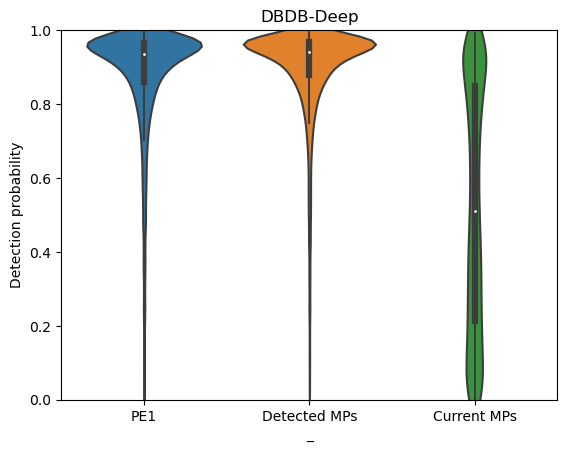

In [23]:
plt.title('DBDB-Deep')

sns.violinplot(data=df_sns, x='_', y='Detection probability', order=['PE1', 'Detected MPs', 'Current MPs'])
plt.ylim(0, 1.0)
plt.show()

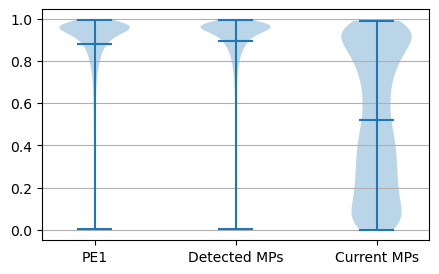

In [31]:
plt.figure(figsize=(5,3))
# plt.title('DBDB-Deep')
# plt.ylabel('Detection probability')

a = plt.violinplot([pe.probs, dmp.probs, mp.probs],
               showmeans=True,
#                    alpha=0.2
              )
# plt.ylim(0, 1.0)
plt.xticks([y + 1 for y in range(len([pe,dmp,mp]))], ['PE1', 'Detected MPs', 'Current MPs'])
b = plt.grid(axis='y')
# plt.setp(a, alpha=0.2)
plt.show()

In [36]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.show()

NameError: name 'history' is not defined